In [1]:
setwd("..")

In [2]:
source("Source/functions.R")
library("data.table")
library("ggplot2")
library("ggsignif")
library("ggrepel")
library("lme4")
library("car")

Loading required package: Matrix

Loading required package: carData



In [3]:
mito_barcodes <- read.csv("Data/mito_barcodes.csv", as.is = TRUE)
mitoIDs <- mito_barcodes[, "ID"] 

snv_info <- read.csv("Data/snv_loci_v2.csv", as.is = TRUE)
snvIDs <- snv_info[,"SNVID"]

chrmbases <- readLines("Data/mm10.mito/chrM.fa")[-1]
chrmbases <- paste0(chrmbases, collapse = "")
chrmbases <- strsplit(chrmbases, "")[[1]]
nchrmbases <- length(chrmbases)

MitoInfo <- fread(file = "Report/metadata/MitoInfo.csv")
MitoInfo[, ExptID := factor(ExptID)]
MitoInfo[, MitoID := factor(MitoID, levels = mitoIDs)]

CellInfo <- fread("Report/metadata/CellInfo.csv")

MouseInfo <- fread("Report/metadata/MouseInfo.csv")

support_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
inherited_posmuts <- support_byposmut[nmice >= 3, posmut]

In [4]:
noctrl_nposhasdata_bymito <- fread("Report/SNVs/QC/highdepth_noctrl_nposhasdata_bymito.csv")
noctrl_nposhasdata_bymito[is.na(nposhasdata), nposhasdata := 0]

noctrl_npos_bymito <- fread("Report/SNVs/QC/highdepth_highaf_noctrl_npos_bymito.csv")
noctrl_npos_bymito <- merge.data.table(noctrl_npos_bymito, noctrl_nposhasdata_bymito[, c("LibraryMitoID", "nposhasdata")], by = "LibraryMitoID")

ANOVA to test whether cell type contribute to the number of SNV sites variance

In [5]:
car::Anova(mod <- lme4::lmer(log1p(npos) ~ CellType + (1 | MouseID) + log1p(nposhasdata), data = noctrl_npos_bymito[MouseID != "Mouse16&17"]), type = 3, test.statistic = "Chisq")

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),232.24438,1,1.931485e-52
CellType,1.58477,1,2.080750e-01
log1p(nposhasdata),1161.09294,1,1.741829e-254


Let's skip ANOVA but just use the mixed-effect linear model coefficients.

In [6]:
mod <- lme4::lmer(log1p(npos) ~ CellType + (1 | MouseID) + log1p(nposhasdata), data = noctrl_npos_bymito[MouseID != "Mouse16&17"])
summary(mod)[[10]]["CellTypeNeuron", "Estimate"]

[1] -0.04986401

In [7]:
set.seed(2021)
rnd_npos_ls <- replicate(1000, { X <- copy(noctrl_npos_bymito[MouseID != "Mouse16&17"]); X[, CellType := sample(CellType)]; X }, simplify = FALSE)
rnd_npos_lme <- lapply(seq_along(rnd_npos_ls), function(i) {
    lme4::lmer(log1p(npos) ~ CellType + (1 | MouseID) + log1p(nposhasdata), data = rnd_npos_ls[[i]])
})
rnd_npos_lme_celltypestats <- sapply(rnd_npos_lme, function(X) summary(X)[[10]]["CellTypeNeuron", "Estimate"])

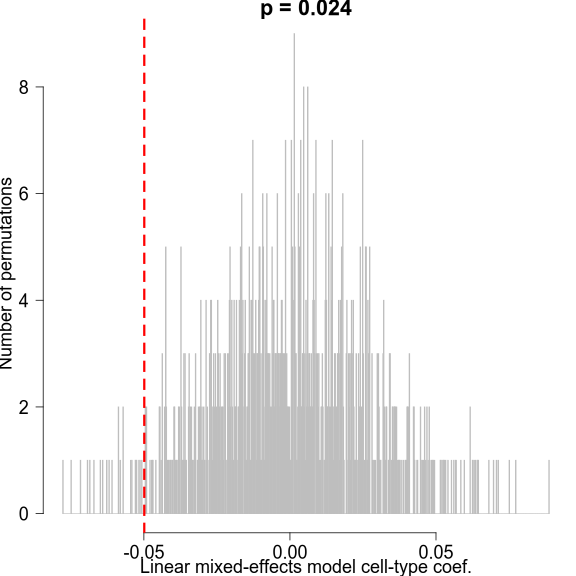

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 72)
par(ps = 18, lend = 2, las = 1, ljoin = 1, bty = "L", mfrow = c(1, 1), mar = c(3, 3, 1, 0.5), oma = c(0, 0, 0, 0), mgp = c(2, 1, 0))
hist(rnd_npos_lme_celltypestats, main = sprintf("p = %.3f", if (summary(mod)[[10]]["CellTypeNeuron", "Estimate"] < 0) { mean(rnd_npos_lme_celltypestats < summary(mod)[[10]]["CellTypeNeuron", "Estimate"]) } else { mean(rnd_npos_lme_celltypestats > summary(mod)[[10]]["CellTypeNeuron", "Estimate"]) }), xlab = "Linear mixed-effects model cell-type coef.", ylab = "Number of permutations", border = "gray", nclass = 1000)
abline(v = summary(mod)[[10]]["CellTypeNeuron", "Estimate"], lty = 2, lwd = 3, col = "red")

Use `hassnv` as a binary indicator and do a logistic regression to see if one cell type is more likely to have more # of SNVs

In [9]:
inherited_noctrl_hassnv_bymito_byposmut <- fread("Report/SNVs/origin/highdepth_highaf_inherited_noctrl_hassnv_bymito_byposmut.csv")
inherited_noctrl_hasdata_bymito_byposmut <- fread("Report/SNVs/origin/highdepth_inherited_noctrl_hasdata_bymito_byposmut.csv")
inherited_noctrl_hassnv_bymito_byposmut <- inherited_noctrl_hassnv_bymito_byposmut[MitoInfo[IsCtrl == "N", c("LibraryMitoID")], on = "LibraryMitoID"]
inherited_noctrl_hasdata_bymito_byposmut <- inherited_noctrl_hasdata_bymito_byposmut[MitoInfo[IsCtrl == "N", c("LibraryMitoID")], on = "LibraryMitoID"]
inherited_noctrl_hassnv_bymito_byposmut <- data.table(MitoInfo[IsCtrl == "N", 1:19], inherited_noctrl_hassnv_bymito_byposmut[, -c(1:19)])
inherited_noctrl_hasdata_bymito_byposmut <- data.table(MitoInfo[IsCtrl == "N", 1:19], inherited_noctrl_hasdata_bymito_byposmut[, -c(1:19)])
setnafill(inherited_noctrl_hassnv_bymito_byposmut, fill = 0, cols = names(inherited_noctrl_hassnv_bymito_byposmut)[-c(1:19)])
setnafill(inherited_noctrl_hasdata_bymito_byposmut, fill = 0, cols = names(inherited_noctrl_hasdata_bymito_byposmut)[-c(1:19)])

Since we now condition the model on the non-missing data only, we can ignore the barcode effect, which was shown to impact the missing data rate. 

In [10]:
inherited_noctrl_hassnv_logit_byposmut <- sapply(inherited_posmuts, function(posmut) {
    X <- inherited_noctrl_hassnv_bymito_byposmut[MouseID != "Mouse16&17", c(posmut, "MouseID", "CellType"), with = FALSE] 
    names(X)[1] <- "hassnv"
    Y <- inherited_noctrl_hasdata_bymito_byposmut[MouseID != "Mouse16&17", c(posmut), with = FALSE]
    names(Y)[1] <- "hasdata"
    idx <- Y[, hasdata] == 1
    X <- X[idx]
    tryCatch( {
        mod <- lme4::glmer(hassnv ~ CellType + (1 | MouseID), data = X, family = "binomial")
        summary(mod)[[10]]["CellTypeNeuron", ]
    }, error = function(e) {
        structure(rep(NA, 4), names = c("Estimate",  "Std. Error",  "z value",  "Pr(>|z|)"))
        ## Watch out for nonconverging estimations! To be safe, we simply don't trust any of them.
    }, warning = function(w) {
        structure(rep(NA, 4), names = c("Estimate",  "Std. Error",  "z value",  "Pr(>|z|)"))
    })
}, simplify = FALSE)

inherited_noctrl_hassnv_logit_byposmut <- do.call(rbind, inherited_noctrl_hassnv_logit_byposmut)
inherited_noctrl_hassnv_logit_byposmut <- data.table(posmut = inherited_posmuts, inherited_noctrl_hassnv_logit_byposmut)
inherited_noctrl_hassnv_logit_byposmut[, padj := p.adjust(`Pr(>|z|)`)]
inherited_noctrl_hassnv_logit_byposmut <- inherited_noctrl_hassnv_logit_byposmut[order(`Pr(>|z|)`)]
dim(inherited_noctrl_hassnv_logit_byposmut)

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) 

[1] 161   6

In [ ]:
head(inherited_noctrl_hassnv_logit_byposmut)
fwrite(inherited_noctrl_hassnv_logit_byposmut, file = "Report/SNVs/diff/inherited_noctrl_hassnv_logit_byposmut.csv")

posmut,Estimate,Std. Error,z value,Pr(>|z|),padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9419:C>T,-2.235813,1.062354,-2.104584,0.03532756,1
1228:G>A,-2.632634,1.263318,-2.083904,0.03716888,1
9027:G>A,1.004806,0.486506,2.065352,0.03888971,1
16096:C>T,2.001568,1.077256,1.858026,0.06316538,1
13786:C>A,2.072608,1.115690,1.857691,0.06321292,1
3051:G>T,-1.901525,1.146684,-1.658282,0.09726063,1


Comparing the fraction of mitos with SNV per mito between astrocytes and neurons. We set a limit to include cells with enough number of mitos. 

In [12]:
inherited_noctrl_fmitoshassnv_bycell_byposmut <- fread("Report/SNVs/origin/highdepth_highaf_inherited_noctrl_fmitoshassnv_bycell_byposmut.csv")
inherited_noctrl_nmitoshasdata_bycell_byposmut <- fread(file = "Report/SNVs/origin/highdepth_inherited_noctrl_nmitoshasdata_bycell_byposmut.csv")
inherited_noctrl_fmitoshassnv_bycell_byposmut <- inherited_noctrl_fmitoshassnv_bycell_byposmut[CellInfo[, "CellUID"], on = "CellUID"]
inherited_noctrl_nmitoshasdata_bycell_byposmut <- inherited_noctrl_nmitoshasdata_bycell_byposmut[CellInfo[, "CellUID"], on = "CellUID"]

In [13]:
nmitoshasdata_th <- 3
inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut <- sapply(inherited_posmuts, function(posmut) {
    X <- inherited_noctrl_nmitoshasdata_bycell_byposmut[MouseID != "Mouse16&17"]
    Y <- inherited_noctrl_fmitoshassnv_bycell_byposmut[MouseID != "Mouse16&17"]
    x <- X[, get(posmut)] 
    idx <- x >= nmitoshasdata_th
    Y <- Y[idx, c(posmut, "MouseID", "CellType", "CellUID"), with = FALSE]
    x <- x[idx]
    names(Y)[1] <- "fmitoshassnv"
    Y[, nmitoshasdata := x]
    tryCatch( {
    ## https://stats.stackexchange.com/questions/233366/how-to-fit-a-mixed-model-with-response-variable-between-0-and-1
    ## We need to watch out for failed SNVs. Just set them to NA. 
        res <- lme4::glmer(fmitoshassnv ~ CellType + (1 | MouseID), data = Y, family = "binomial", weight = nmitoshasdata)
        summary(res)[[10]]["CellTypeNeuron", ]
    }, error = function(e) { 
        structure(rep(NA, 4), names = c("Estimate",  "Std. Error",  "z value",  "Pr(>|z|)")) 
    }, warning = function(w) {
        structure(rep(NA, 4), names = c("Estimate",  "Std. Error",  "z value",  "Pr(>|z|)")) 
    })
}, simplify = FALSE)
inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut <- do.call(rbind, inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut)
inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut <- data.table(posmut = rownames(inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut), inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut)
inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut[, padj := p.adjust(`Pr(>|z|)`)]
inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut <- inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut[order(`Pr(>|z|)`)]
dim(inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut)

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) 

[1] 161   6

In [ ]:
head(inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut)
fwrite(inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut, file = "Report/SNVs/diff/inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut.csv")

posmut,Estimate,Std. Error,z value,Pr(>|z|),padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9419:C>T,-2.2324667,1.0623823,-2.101378,0.03560780,1
9027:G>A,0.9519112,0.4904074,1.941062,0.05225076,1
13786:C>A,2.0762937,1.1216126,1.851168,0.06414533,1
16096:C>T,1.9892899,1.0791431,1.843398,0.06527097,1
16073:C>T,2.0914305,1.1725304,1.783690,0.07447410,1
3051:G>T,-1.8919791,1.1455756,-1.651553,0.09862567,1


Make a figure pooling all mice, using the stats from fmitoshassnv logistic regression, excluding the low-mito cells

In [15]:
inherited_noctrl_fmitoshassnv_bycell_byposmut <- fread("Report/SNVs/origin/highdepth_highaf_inherited_noctrl_fmitoshassnv_bycell_byposmut.csv")
inherited_noctrl_nmitoshasdata_bycell_byposmut <- fread(file = "Report/SNVs/origin/highdepth_inherited_noctrl_nmitoshasdata_bycell_byposmut.csv")
inherited_noctrl_fmitoshassnv_bycell_byposmut <- inherited_noctrl_fmitoshassnv_bycell_byposmut[CellInfo[, "CellUID"], on = "CellUID"]
inherited_noctrl_nmitoshasdata_bycell_byposmut <- inherited_noctrl_nmitoshasdata_bycell_byposmut[CellInfo[, "CellUID"], on = "CellUID"]

inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut <- fread(file = "Report/SNVs/diff/inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut.csv")
nmitoshasdata_th <- 3

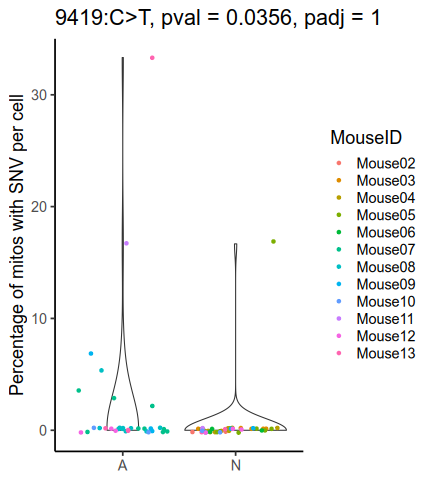

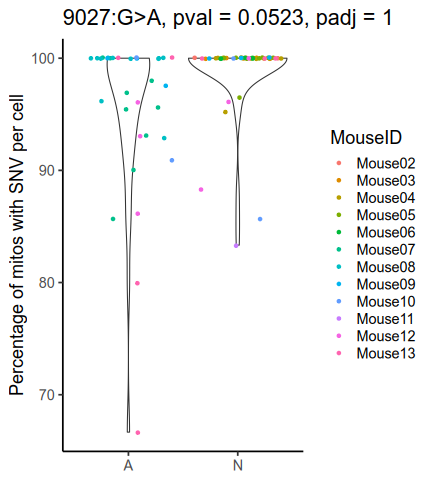

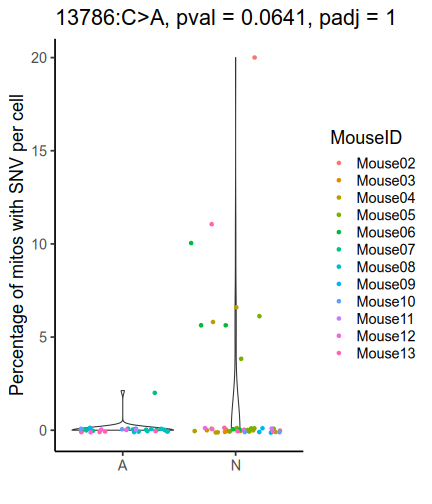

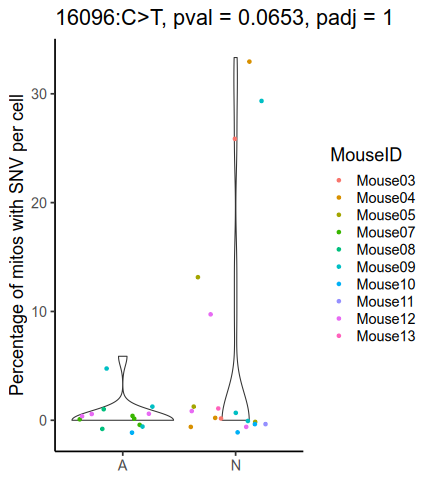

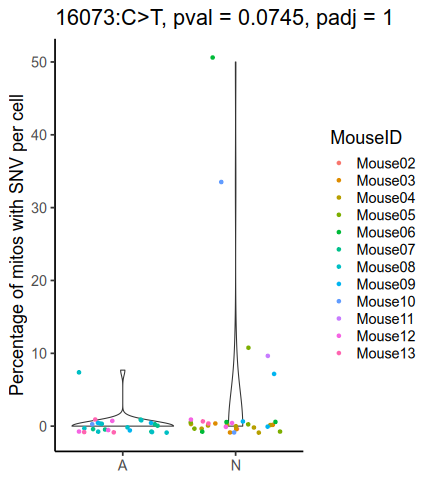

In [16]:
options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 72)
for (posmut in inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut[!is.na(`Pr(>|z|)`)][order(`Pr(>|z|)`)][, head(posmut, 5)]) {
    pval <- inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut[posmut, `Pr(>|z|)`, on = "posmut"]
    padj <- inherited_noctrl_fmitoshassnv_nolowmito_logit_byposmut[posmut, `padj`, on = "posmut"]
    X <- copy(inherited_noctrl_fmitoshassnv_bycell_byposmut[MouseID != "Mouse16&17"])
    X[, MouseID := factor(MouseID, levels = sort(unique(MouseID)))]
    Y <- inherited_noctrl_nmitoshasdata_bycell_byposmut[MouseID != "Mouse16&17"]
    y <- Y[, get(posmut)]
    idx <- y >= nmitoshasdata_th
    print(ggplot(X[idx], aes(x = CellType, y = 100 * get(posmut))) + theme_classic(base_size = 18) + geom_violin() + geom_jitter(alpha = 1, aes(col = MouseID)) + xlab("") + ylab("Percentage of mitos with SNV per cell") + ggtitle(sprintf("%s, pval = %.3g, padj = %.3g", posmut, pval, padj)) + scale_x_discrete(labels = c("Astrocyte" = "A", "Neuron" = "N")))
}

Finally, we went to compare the variance between astrocytes and neurons.

In [17]:
inherited_noctrl_altasin_bymito_byposmut <- fread(file = "Report/SNVs/hierarchy/inherited_noctrl_altasin_bymito_byposmut.csv")
inherited_noctrl_altasin_astro_nestedaov_byposmut <- sapply(inherited_posmuts, function(posmut) {
    X <- inherited_noctrl_altasin_bymito_byposmut[MouseID != "Mouse16&17" & CellType == "Astrocyte", c(posmut, "MouseID", "CellUID", "CellType", "MitoID"), with = FALSE]
    names(X)[1] <- "VAF"
    mod <- aov(VAF ~ MouseID + Error(CellUID), data = X)
    X <- rbind(as.data.frame(summary(mod)[[1]][[1]]), as.data.frame(summary(mod)[[2]][[1]]))
    rownames(X) <- c("mouse", "cell", "mito")
    X
}, simplify = FALSE)
inherited_noctrl_altasin_neuron_nestedaov_byposmut <- sapply(inherited_posmuts, function(posmut) {
    X <- inherited_noctrl_altasin_bymito_byposmut[MouseID != "Mouse16&17" & CellType == "Neuron", c(posmut, "MouseID", "CellUID", "CellType", "MitoID"), with = FALSE]
    names(X)[1] <- "VAF"
    mod <- aov(VAF ~ MouseID + Error(CellUID), data = X)
    X <- rbind(as.data.frame(summary(mod)[[1]][[1]]), as.data.frame(summary(mod)[[2]][[1]]))
    rownames(X) <- c("mouse", "cell", "mito")
    X
}, simplify = FALSE)

inherited_noctrl_altasin_vartest_byposmut <- t(mapply(
    function(X, Y) {
        dfx <- X["mito", "Df"]; dfy <- Y["mito", "Df"]
        msx <- X["mito", "Mean Sq"]; msy <- Y["mito", "Mean Sq"]
        fx <- msx / msy
        pval <- ifelse(
            fx > 1, 
            pf(fx, df1 = dfx, df2 = dfy, lower.tail = FALSE) + pf(1/fx, df1 = dfx, df2 = dfy, lower.tail = TRUE), 
            ifelse(
                fx < 1, 
                pf(fx, df1 = dfx, df2 = dfy, lower.tail = TRUE) + pf(1/fx, df1 = dfx, df2 = dfy, lower.tail = FALSE), 
                NA
            )
        )
        c(df_astro = dfx, 
          df_neuron = dfy,
          ms_astro = msx, 
          ms_neuron = msy, 
          fstat_astro_to_neuron = fx, 
          fstat_neuron_to_astro = 1/fx, 
          pval = pval
        )
    }, X = inherited_noctrl_altasin_astro_nestedaov_byposmut, Y = inherited_noctrl_altasin_neuron_nestedaov_byposmut
))
inherited_noctrl_altasin_vartest_byposmut <- data.table(posmut = inherited_posmuts, inherited_noctrl_altasin_vartest_byposmut)
inherited_noctrl_altasin_vartest_byposmut[, padj := p.adjust(pval)]
inherited_noctrl_altasin_vartest_byposmut <- inherited_noctrl_altasin_vartest_byposmut[order(pval)]
dim(inherited_noctrl_altasin_vartest_byposmut)

[1] 161   9

In [ ]:
head(inherited_noctrl_altasin_vartest_byposmut)
fwrite(inherited_noctrl_altasin_vartest_byposmut, file = "Report/SNVs/diff/inherited_noctrl_altasin_vartest_byposmut.csv")

posmut,df_astro,df_neuron,ms_astro,ms_neuron,fstat_astro_to_neuron,fstat_neuron_to_astro,pval,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1244:G>A,335,336,0.0004543346,0.0054143835,0.08391254,11.9171706,2.798026e-93,4.504822e-91
1228:G>A,332,337,0.0027517601,0.0002958671,9.30066361,0.1075192,5.376096e-78,8.601754e-76
8932:C>T,626,722,0.0007697213,0.0002392145,3.21770374,0.3107806,3.457199e-48,5.496946e-46
16073:C>T,228,219,0.0010656559,0.0082619119,0.12898418,7.7528887,1.575162e-45,2.488756e-43
1270:G>A,326,322,0.0007068648,0.0034183596,0.20678479,4.8359457,1.103570e-41,1.732605e-39
3021:A>G,334,343,0.0008734290,0.0033583218,0.26007902,3.8449853,6.666127e-33,1.039916e-30


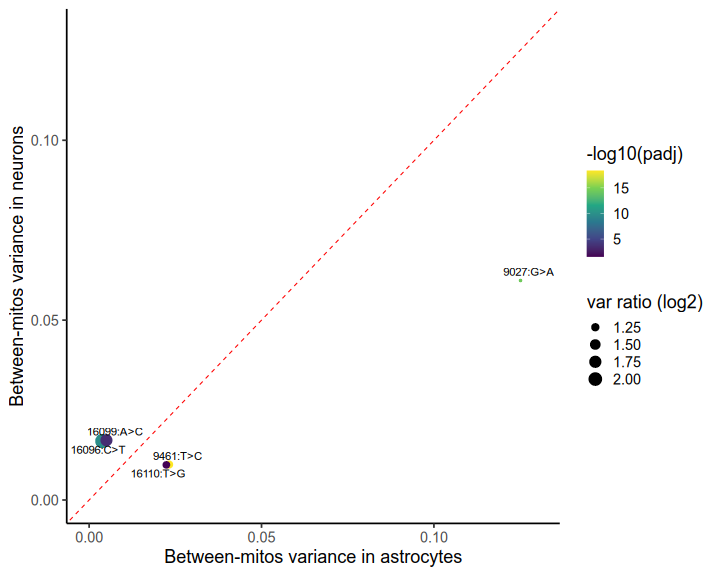

In [19]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 72)
ggplot(inherited_noctrl_altasin_vartest_byposmut[(ms_astro > 0.01 | ms_neuron > 0.01) & padj < 0.05], aes(x = (ms_astro), y = (ms_neuron))) + geom_point(aes(color = -log10(padj), size = log2(pmax(fstat_astro_to_neuron, fstat_neuron_to_astro)))) + geom_text_repel(aes(x = (ms_astro), y = (ms_neuron), label = posmut), size = 4, max.overlaps = 10, data = inherited_noctrl_altasin_vartest_byposmut[(ms_astro > 0.01 | ms_neuron > 0.01) & padj < 0.05]) + geom_abline(slope = 1, intercept = 0, color = "red", linetype = 2) + theme_classic(base_size = 18) + xlab("Between-mitos variance in astrocytes") + ylab("Between-mitos variance in neurons") + scale_x_continuous(limits = c(0, 0.13)) + scale_y_continuous(limits = c(0, 0.13)) + guides(size = guide_legend("var ratio (log2)")) + scale_color_viridis_c()

hN/hS from Li et al. 2015 PNAS methods

In [20]:
highdepth_highaf <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd.csv.gz")
highdepth_highaf_noctrl <- highdepth_highaf[IsCtrl == "N"]
highdepth_highaf_noctrl[ref == "A", A := `=`]
highdepth_highaf_noctrl[ref == "C", C := `=`]
highdepth_highaf_noctrl[ref == "G", G := `=`]
highdepth_highaf_noctrl[ref == "T", T := `=`]
highdepth_highaf_noctrl <- melt.data.table(highdepth_highaf_noctrl, measure.vars = c("A", "C", "G", "T", "del"), variable.name = "alt", value.name = "altperc")
setnames(highdepth_highaf_noctrl, "=", "refperc")

highdepth_highaf_noctrl <- highdepth_highaf_noctrl[ref != alt]
vaf_th <- 0.05
highdepth_highaf_noctrl <- highdepth_highaf_noctrl[altperc >= vaf_th * 100]

highdepth_highaf_noctrl[, alt := factor(alt, levels = c("A", "C", "G", "T", "del"))]
highdepth_highaf_noctrl[, mut := factor(paste0(ref, ">", alt), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "del")))]
setkey(highdepth_highaf_noctrl, pos, alt)
highdepth_highaf_noctrl[, posmut := paste0(pos, ":", mut)]
highdepth_highaf_noctrl[, posmut := factor(posmut, levels = unique(posmut))]

highdepth_highaf_noctrl_astrocyte <- highdepth_highaf_noctrl[CellType == "Astrocyte"]
highdepth_highaf_support_astrocyte <- highdepth_highaf_noctrl_astrocyte[, list(SNVID = unique(SNVID), nmice = uniqueN(MouseID), ncells = uniqueN(CellUID), nmitos = uniqueN(LibraryMitoID)), by = "posmut"]
highdepth_highaf_support_astrocyte[, pos := as.integer(sapply(strsplit(as.character(posmut), ":"), '[', 1))]
highdepth_highaf_support_astrocyte[, mut := sapply(strsplit(as.character(posmut), ":"), '[', 2)]
highdepth_highaf_support_astrocyte[, ref := sapply(strsplit(as.character(mut), ">"), '[', 1)]
highdepth_highaf_support_astrocyte[, alt := sapply(strsplit(as.character(mut), ">"), '[', 2)]
setcolorder(highdepth_highaf_support_astrocyte, c("posmut", "SNVID", "pos", "mut", "ref", "alt", "nmice", "ncells", "nmitos"))

highdepth_highaf_noctrl_neuron <- highdepth_highaf_noctrl[CellType == "Neuron"]
highdepth_highaf_support_neuron <- highdepth_highaf_noctrl_neuron[, list(SNVID = unique(SNVID), nmice = uniqueN(MouseID), ncells = uniqueN(CellUID), nmitos = uniqueN(LibraryMitoID)), by = "posmut"]
highdepth_highaf_support_neuron[, pos := as.integer(sapply(strsplit(as.character(posmut), ":"), '[', 1))]
highdepth_highaf_support_neuron[, mut := sapply(strsplit(as.character(posmut), ":"), '[', 2)]
highdepth_highaf_support_neuron[, ref := sapply(strsplit(as.character(mut), ">"), '[', 1)]
highdepth_highaf_support_neuron[, alt := sapply(strsplit(as.character(mut), ">"), '[', 2)]
setcolorder(highdepth_highaf_support_neuron, c("posmut", "SNVID", "pos", "mut", "ref", "alt", "nmice", "ncells", "nmitos"))

In [21]:
vertmtcodon <- fread(file = "Report/evo/vertmtcodon.csv")
vertmtcodon[, CDS_position:= as.integer(CDS_position)]
vertmtcodon[, codon_index := round((CDS_position+1)/3)]

noctrl_vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
noctrl_vep_cds <- noctrl_vep[class  == "synonymous" | class == "nonsynonymous"]
support_byposmut_cds <- support_byposmut[posmut %in% noctrl_vep_cds[, unique(posmut)]]
chrmbases_properties <- fread("Report/artifact/chrmbases_properties.csv.gz")
chrmgenes <- fread("Report/artifact/chrmgenes.csv")
chrmgenes_cds <- chrmgenes[c(6, 10, 16, 19, 21, 22, 23, 25, 27, 28, 32, 33, 35)]
chrmbases_properties[, is_cds := ifelse(sapply(pos, function(p) { any(sapply(1:chrmgenes_cds[,.N], function(x) { b <- chrmgenes_cds[x]; p >= b[, start] & p <= b[, end] })) }), "Y", "N")]
chrmbases_covered_cds <- chrmbases_properties[is_in_range == "Y" & is_in_primer == "N" & is_cds == "Y"]

In [22]:
kaks <- Genetics$KaKs(total_pos = chrmbases_covered_cds[, pos], var_pos = support_byposmut_cds[, unique(pos)], vertmtcodon = vertmtcodon[, c("pos", "strand", "symbol", "codon_index", "S", "N")])
kaks

[1] 0.9808154

In [23]:
noctrl_transmat_cds <- dcast.data.table(support_byposmut_cds[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
kaks_rand <- replicate(3000, {
    rand_muts <- Genetics$mutate_from_transmut(chrmbases_covered_cds[, pos], ref = chrmbases_covered_cds[, ref], transmut = noctrl_transmat_cds)
    Genetics$KaKs(total_pos = chrmbases_covered_cds[, pos], var_pos = rand_muts[, unique(pos)], vertmtcodon = vertmtcodon[, c("pos", "strand", "symbol", "codon_index", "S", "N")])
})

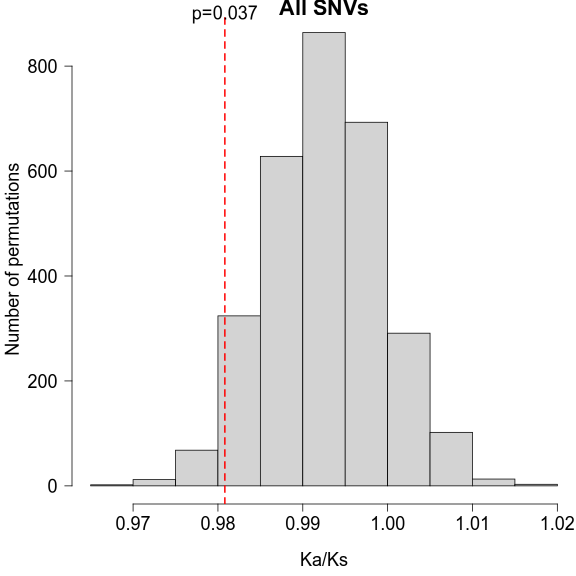

In [24]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 72)
par(ps = 18, las = 1, lend = 2, ljoin = 1, bty = "L", mar = c(5, 5, 1, 0), oma = c(0, 0, 0, 0), mgp = c(3.5, 1, 0))
hist(kaks_rand, xlab = "Ka/Ks", ylab = "Number of permutations", main = "All SNVs")
abline(v = kaks, lwd = 2, col = "red", lty = 2)
text(x = kaks, y =par()$usr[3] + 1.00 * (par()$usr[4] - par()$usr[3]), labels = sprintf("p=%0.3f", mean(kaks_rand < kaks)), xpd = TRUE)

In [25]:
support_byposmut_cds_astrocyte <- highdepth_highaf_support_astrocyte[posmut %in% noctrl_vep_cds[, unique(posmut)]]
noctrl_transmat_cds_astrocyte <- dcast.data.table(support_byposmut_cds_astrocyte[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
kaks_astrocyte <- Genetics$KaKs(total_pos = chrmbases_covered_cds[, pos], var_pos = support_byposmut_cds_astrocyte[, unique(pos)], vertmtcodon = vertmtcodon[, c("pos", "strand", "symbol", "codon_index", "S", "N")])
kaks_astrocyte

[1] 0.9795673

In [26]:
kaks_rand_astrocyte <- replicate(3000, {
    rand_muts <- Genetics$mutate_from_transmut(chrmbases_covered_cds[, pos], ref = chrmbases_covered_cds[, ref], transmut = noctrl_transmat_cds_astrocyte)
    Genetics$KaKs(total_pos = chrmbases_covered_cds[, pos], var_pos = rand_muts[, unique(pos)], vertmtcodon = vertmtcodon[, c("pos", "strand", "symbol", "codon_index", "S", "N")])
})

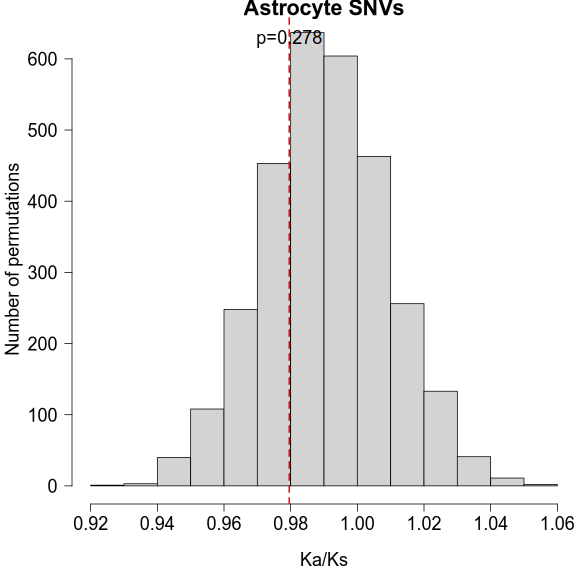

In [27]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 72)
par(ps = 18, las = 1, lend = 2, ljoin = 1, bty = "L", mar = c(5, 5, 1, 0), oma = c(0, 0, 0, 0), mgp = c(3.5, 1, 0))
hist(kaks_rand_astrocyte, xlab = "Ka/Ks", ylab = "Number of permutations", main = "Astrocyte SNVs")
abline(v = kaks_astrocyte, lwd = 2, col = "red", lty = 2)
text(x = kaks_astrocyte, y = par()$usr[3] + 0.95 * (par()$usr[4] - par()$usr[3]), labels = sprintf("p=%0.3f", mean(kaks_rand_astrocyte < kaks_astrocyte)), xpd = TRUE)

In [28]:
support_byposmut_cds_neuron <- highdepth_highaf_support_neuron[posmut %in% noctrl_vep_cds[, unique(posmut)]]
noctrl_transmat_cds_neuron <- dcast.data.table(support_byposmut_cds_neuron[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
kaks_neuron <- Genetics$KaKs(total_pos = chrmbases_covered_cds[, pos], var_pos = support_byposmut_cds_neuron[, unique(pos)], vertmtcodon = vertmtcodon[, c("pos", "strand", "symbol", "codon_index", "S", "N")])
kaks_neuron

[1] 0.9563315

In [29]:
kaks_rand_neuron <- replicate(3000, {
    rand_muts <- Genetics$mutate_from_transmut(chrmbases_covered_cds[, pos], ref = chrmbases_covered_cds[, ref], transmut = noctrl_transmat_cds_neuron)
    Genetics$KaKs(total_pos = chrmbases_covered_cds[, pos], var_pos = rand_muts[, unique(pos)], vertmtcodon = vertmtcodon[, c("pos", "strand", "symbol", "codon_index", "S", "N")])
})

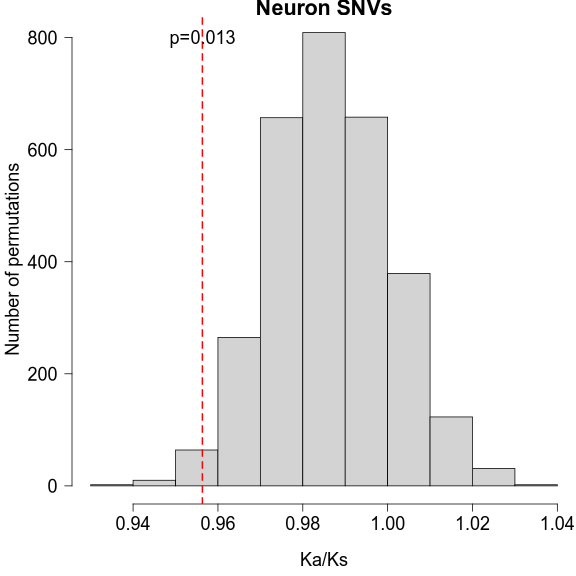

In [30]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 72)
par(ps = 18, las = 1, lend = 2, ljoin = 1, bty = "L", mar = c(5, 5, 1, 0), oma = c(0, 0, 0, 0), mgp = c(3.5, 1, 0))
hist(kaks_rand_neuron, xlab = "Ka/Ks", ylab = "Number of permutations", main = "Neuron SNVs")
abline(v = kaks_neuron, lwd = 2, col = "red", lty = 2)
text(x = kaks_neuron, y = par()$usr[3] + 0.95 * (par()$usr[4] - par()$usr[3]), labels = sprintf("p=%0.3f", mean(kaks_rand_neuron < kaks_neuron)), xpd = TRUE)

In [31]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] car_3.1-3         carData_3.0-5     lme4_1.1-35.5     Matrix_1.7-0     
[5] ggrepel_0.9.6     ggsignif_0.6.4    ggplot2_3.5.1     data.table_1.16.2

loaded via a namespac